<a href="https://colab.research.google.com/github/gyq1985/deepmindset/blob/main/Google_Collab_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
data_path = "/content/drive/Shareddrives/Deepmindset/dataset/clean_dataset/images"
# data_path = "/content/small_dataset"
# Use enhanced data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class labels:", train_generator.class_indices)
print("Number of training images:", train_generator.samples)
print("Number of validation images:", val_generator.samples)

# Build lightweight CNN with higher dropout
from tensorflow.keras import layers, models, Input

model = models.Sequential([
    Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Increased dropout
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model with EarlyStopping
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Class labels: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
Number of training images: 960
Number of validation images: 240


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 528s 18s/step - accuracy: 0.2704 - loss: 2.5077 - val_accuracy: 0.5125 - val_loss: 1.1374
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 956ms/step - accuracy: 0.4482 - loss: 1.1908 - val_accuracy: 0.6125 - val_loss: 0.9727
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 864ms/step - accuracy: 0.5147 - loss: 1.1062 - val_accuracy: 0.5333 - val_loss: 0.9692
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 839ms/step - accuracy: 0.5573 - loss: 1.0091 - val_accuracy: 0.6042 - val_loss: 0.9408
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 787ms/step - accuracy: 0.5983 - loss: 0.9610 - val_accuracy: 0.6042 - val_loss: 0.8897
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 867ms/step - accuracy: 0.5869 - loss: 0.9665 - val_accuracy: 0.6292 - val_loss: 0.8608
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 853ms/step - accuracy: 0.5879 - loss: 0.9400 - val_accuracy: 0.6208 - val_loss: 0.8224
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 866ms/step - accuracy: 0.5780 - loss: 0.9399 - val_accur

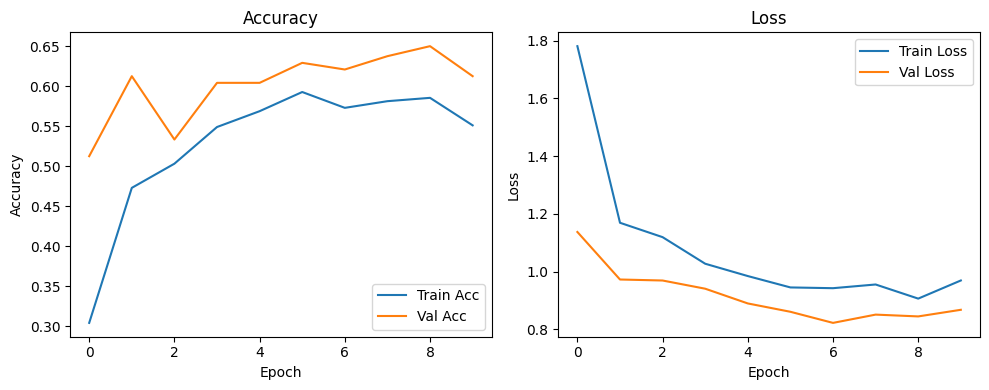

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step


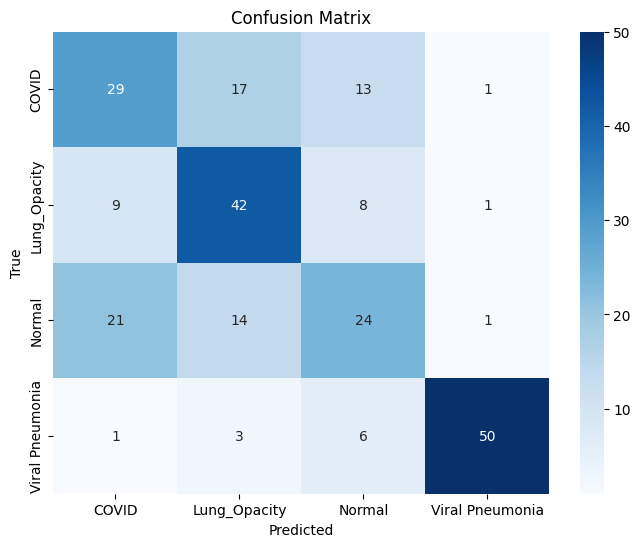

Classification Report:

                 precision    recall  f1-score   support

          COVID       0.48      0.48      0.48        60
   Lung_Opacity       0.55      0.70      0.62        60
         Normal       0.47      0.40      0.43        60
Viral Pneumonia       0.94      0.83      0.88        60

       accuracy                           0.60       240
      macro avg       0.61      0.60      0.60       240
   weighted avg       0.61      0.60      0.60       240



In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

val_generator.reset()
Y_true = val_generator.classes
Y_pred = np.argmax(model.predict(val_generator), axis=1)

labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=labels))

In [ ]:
# save model
model.save("/content/drive/Shared drives/Deepmindset/model/cnn_poc_model.h5")